In [1]:
### Use gpd environment (a clean environment for geopandas)

In [398]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import pylab as pl
import os
from IPython import display
from subprocess import call
from datetime import datetime
import subprocess
import sys
sys.path.append('/Users/vsriniv/Documents/Research/Github/PatchSim')
sys.path.append('/Users/brylew/NSSACgit/PatchSim')
import patchsim as sim
import matplotlib.pyplot as plt
%matplotlib inline

### Cleaning OD_Matrix_v3 and restricting to Nord-Kivu, Ituri

In [399]:
# od_matrix = pd.read_csv('../data/pop_travel/OD_Matrix_v3_orig.csv')
# od_matrix = od_matrix[~od_matrix.Destination.str.startswith('POE_')] ## Dropping points of entry

# pop2018 = pd.read_csv('../data/pop_travel/DRC_Pop2018.csv')
# pop2018['ADM2_caps'] = pop2018.ADM2_NAME.str.upper()

# ## Matching names from shape file or OD_matrix
# match_dict = {'BAMBU':'BAMBU-MINES',
#              'MONGBALU':'MONGBWALU',
#              'NYAKUNDE':'NYANKUNDE',
#              'KATOYI':'KITOYI'}
# pop2018['ADM2_caps'] = pop2018.ADM2_caps.apply(lambda x: match_dict[x] if x in match_dict.keys() else x)

# ## Restricting analyses to Nord-Kivu and Ituri province health zones
# pop2018 = pop2018[(pop2018.ADM1_NAME.isin(['Nord-Kivu','Ituri']))]
# pop2018 = pop2018[['ADM2_caps','Pop2018']]
# od_matrix = od_matrix.merge(pop2018,left_on='Origin',right_on='ADM2_caps').merge(pop2018,left_on='Destination',right_on='ADM2_caps')
# od_matrix.drop(['ADM2_caps_x','ADM2_caps_y'],axis=1,inplace=True)
# od_matrix = od_matrix[['Origin','Pop2018_x','Destination','Pop2018_y','Travel_Time']]
# od_matrix.columns = ['Origin','Origin_Pop','Destination','Destination_Pop','Travel_Time']
# od_matrix.to_csv('../data/pop_travel/OD_Matrix_v3_cleaned.csv',index=None)

### Preparing PatchSim PatchFile and NetworkFile (Gravity) v3

In [400]:
# od_matrix = pd.read_csv('../data/pop_travel/OD_Matrix_v3_cleaned.csv')
# od_matrix['Grav'] = (od_matrix.Origin_Pop*od_matrix.Destination_Pop)/(od_matrix.Travel_Time**2)
# od_matrix = od_matrix.assign(norm_flow=od_matrix.Grav.div(od_matrix.groupby(['Origin']).Grav.transform('sum')))
# od_matrix = od_matrix[['Origin','Destination','norm_flow']]
# hz = od_matrix.Origin.unique()
# non_commute=0.85
# df = pd.DataFrame({'Origin':hz,'Destination':hz,'norm_flow':np.repeat(non_commute,len(hz))})
# od_matrix.norm_flow = od_matrix.norm_flow*(1-non_commute)
# od_matrix = od_matrix.append(df[['Origin','Destination','norm_flow']])
# od_matrix['temp'] = 0
# od_matrix.Origin = od_matrix.Origin.str.replace(' ','_')
# od_matrix.Destination = od_matrix.Destination.str.replace(' ','_')
# od_matrix[['Origin','Destination','temp','norm_flow']].to_csv('../data/patchsim/grav_drc_v3.csv',sep=' ',index=None,header=None)

# df = pd.read_csv('../data/pop_travel/OD_Matrix_v3_cleaned.csv')
# df = df[['Origin','Origin_Pop']].drop_duplicates()
# df.Origin = df.Origin.str.replace(' ','_')
# df.to_csv('../data/patchsim/pop_drc_v3.csv',sep=' ',index=None,header=None)

### Running PatchSim on v3 files

In [544]:
stages = 4
sc = 'a' # sc='a' for baseline, sc='b' for pull-out

for s in range(stages):
    if s!=3:
        sim.run_disease_simulation(sim.read_config('../data/patchsim/cfg_stage{}.txt'.format(s)),write_epi=True)
    else:
        sim.run_disease_simulation(sim.read_config('../data/patchsim/cfg_stage{}{}.txt'.format(s,sc)),write_epi=True)

out_df = pd.DataFrame()
for s in range(stages):
    if s!=3:
        temp_df = pd.read_csv('../outputs/sample{}.out'.format(s),delimiter=' ',header=None,index_col=0)
    else:
        temp_df = pd.read_csv('../outputs/sample{}{}.out'.format(s,sc),delimiter=' ',header=None,index_col=0)
        
    if s==0:
        out_df = temp_df.copy(deep=True)
    else:
        temp_df.columns = [x+len(out_df.columns) for x in temp_df.columns]
        out_df = out_df.join(temp_df)

### National ground truth vs simulated cases

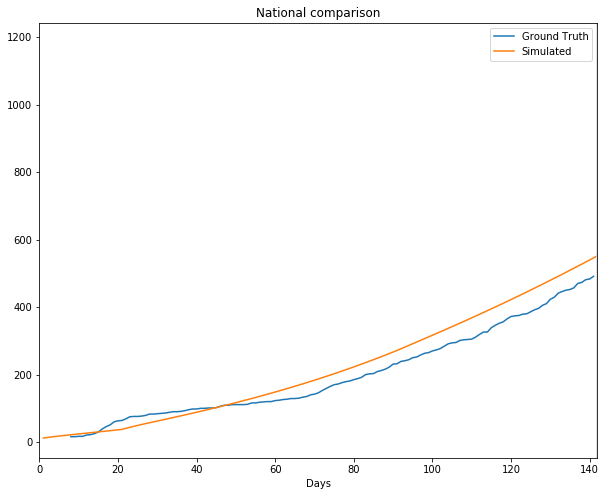

In [548]:
plt.figure(figsize=(10,8))
ax = plt.gca()
evd_df = pd.read_csv('../data/ebola_drc_nordkivu/data/ebola_drc-all.csv')
evd_df['Date'] = evd_df.date.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
gt = evd_df[evd_df.health_zone=='all'].total_c.values
ax.plot(gt,label='Ground Truth')
out_df.sum().cumsum().plot(label='Simulated',ax=ax)
ax.axvline(len(gt),color='#dbdbdb')
plt.title('National comparison')
plt.xlabel('Days')
plt.legend()
plt.xlim([0,len(gt)+30])
plt.savefig('../plots/sim_gt_nat_epicurve_sc{}.png'.format(sc),dpi=100)
plt.xlim([0,len(gt)])
plt.savefig('../plots/sim_gt_nat_epicurve_calib.png',dpi=100)

### Regional ground truth vs simulated cases

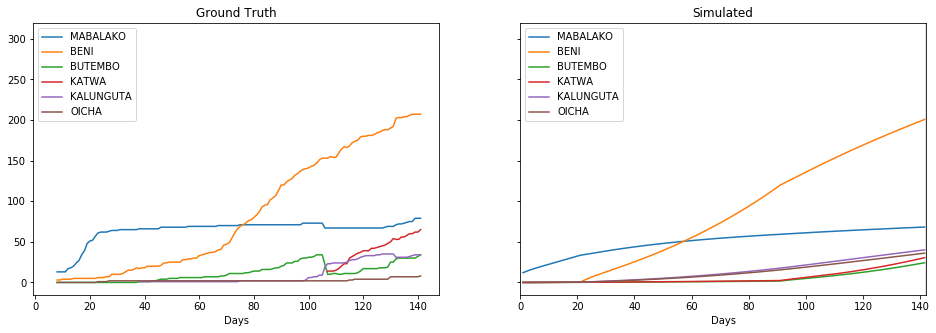

In [549]:
f,axarr = plt.subplots(1,2,figsize=(16,5),sharey=True)
key_hzs = ['MABALAKO','BENI','BUTEMBO','KATWA','KALUNGUTA','OICHA']
for h in key_hzs:
    evd_df[evd_df.health_zone==h.capitalize()].reset_index().plot(y='total_c',ax=axarr[0],label=h)
axarr[0].set_title('Ground Truth')
axarr[0].set_xlabel('Days')

out_df.loc[key_hzs].T.cumsum().plot(ax=axarr[1])
axarr[1].set_title('Simulated')
axarr[1].set_xlabel('Days')
axarr[1].axvline(len(gt),color='#dbdbdb')
l = axarr[1].legend()
l.set_title('')
plt.xlim([0,len(gt)+30])
plt.savefig('../plots/sim_gt_reg_epicurve_sc{}.png'.format(sc),dpi=100)

axarr[1].set_xlim([0,len(gt)])
plt.savefig('../plots/sim_gt_reg_epicurve_calib.png',dpi=100)

### Risk profile for health zones

In [520]:
# ### Converting to Weekly case counts
# out_df.index = out_df.index.str.replace('_',' ')
# out_wk = out_df.groupby((out_df.columns - 1)// 7, axis=1).sum()
# wk_range = out_wk.columns[:-1]
# out_wk = out_wk[wk_range]

# out_wk['Last4'] = out_wk[wk_range[-4:]].sum(axis=1)
# temp_df = out_wk.sort_values('Last4',ascending=False)[['Last4']]
# temp_df['risk_index'] = temp_df.Last4/temp_df.Last4.sum()
# temp_df[['risk_index']].head(10).to_html('../plots/risk_table_sc{}.html'.format(sc))

### Visualizing weekly choropleths

In [521]:
# gdf = gpd.read_file('../data/shapefile/healthzones_v2/DRC_Districts.shp').set_index('ADM2_NAME')
# gdf = gdf.join(out_wk)
# count=0
# for wk in wk_range:
#     f = plt.figure(figsize=(10,10))
#     ax = plt.gca()
#     plt.axis('off')
#     plt.title('Simulated cases in week {}'.format(wk),fontsize=20)
#     gdf[(gdf.ADM1_NAME.isin(['ITURI','NORD KIVU']))].plot(ax=ax,column=wk,cmap='Reds',vmin=0,vmax=10,legend=True)
#     #gdf.plot(ax=ax,column=wk,cmap='Reds',vmin=0,vmax=10,legend=True)
#     display.clear_output(wait=True)
#     display.display(pl.gcf())    
#     plt.savefig('../plots/{:02d}_temp.png'.format(count),bbox_inches='tight')
#     count+=1
#     plt.close()

# cmd_str = "convert -delay 100 -loop 1 ../plots/*.png ../plots/sim_anim_nk_sc{}.gif".format(sc)
# call(cmd_str.split(' '))
# [os.remove('../plots/'+x) for x in os.listdir('../plots') if '_temp.png' in x];

In [522]:
# plt.figure(figsize=(20,20))
# ax = plt.gca()
# gdf = gpd.read_file('../data/shapefile/healthzones_v2/DRC_Districts.shp')
# gdf[gdf.ADM1_NAME.isin(['ITURI','NORD KIVU'])].plot(ax=ax)
# for hz in gdf[gdf.ADM1_NAME.isin(['ITURI','NORD KIVU'])]['ADM2_NAME'].values:
#     plt.annotate(s=hz, xy=(gdf[gdf.ADM2_NAME==hz]['CENTER_LON'],gdf[gdf.ADM2_NAME==hz]['CENTER_LAT']),
#                  horizontalalignment='center')

## Comparing the two scenarios

In [523]:
out_dict = {}

In [526]:
sc = 'b'
out_df = pd.DataFrame()
for s in range(stages):
    if s!=3:
        temp_df = pd.read_csv('../outputs/sample{}.out'.format(s),delimiter=' ',header=None,index_col=0)
    else:
        temp_df = pd.read_csv('../outputs/sample{}{}.out'.format(s,sc),delimiter=' ',header=None,index_col=0)
        
    if s==0:
        out_df = temp_df.copy(deep=True)
    else:
        temp_df.columns = [x+len(out_df.columns) for x in temp_df.columns]
        out_df = out_df.join(temp_df)
out_dict[sc] = out_df

In [543]:
horizon = 90
chop = 90-horizon
tot_a = out_dict['a'].sum().cumsum().values[-1-chop]
tot_b = out_dict['b'].sum().cumsum().values[-1-chop]
print('Percentage Increase due to pull-out at {} days horizon: {}%'.format(horizon,round((tot_b-tot_a)*100/tot_a,2)))
print(int(tot_a),int(tot_b))

Percentage Increase due to pull-out at 90 days horizon: 80.89%
1183 2140
